## FPF Gain approximation code

In [71]:
import numpy as np
from sympy import *
from scipy.spatial.distance import pdist,squareform
from scipy.stats import norm
import scipy.integrate as integrate
import math

from timeit import default_timer as timer

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text',usetex = True)
import seaborn as sns

from sklearn.linear_model import ridge

from IPython.display import clear_output

%matplotlib inline

### Defining some functions

#### Function to generate samples from a multi-dimensional 1d- Gaussian mixture $\times$  (d-1) independnt Gaussian distribution 

In [2]:
def get_samples(N, mu, sigma_b, w, dim,  sigma = None):
    Xi  = np.zeros((N,dim))
    for i in range(N):
        if np.random.uniform() <= w[0]:
            Xi[i,0] = mu[0]  + sigma_b[0] * np.random.normal()
        else:
            Xi[i,0]  = mu[1]  + sigma_b[1] * np.random.normal()
        for d in range(1, dim):
            Xi[i,d] = sigma * np.random.normal()
    return Xi

#### Function to compute the mean square error in gain function approximation

In [3]:
def mean_squared_error(K_exact, K_approx, p):
    N = len(K_exact)
    p_vec = lambdify(x, p, 'numpy')
    mse = (1/N) * np.linalg.norm(K_exact - K_approx)**2
    # mse2 = np.sum(((K_exact - K_approx)**2) *np.concatenate(p_vec(Xi)))
    return mse

### Different gain approximation algorithms

### Function to approximate FPF gain using optimal RKHS method  
uses the extended representer theorem in - https://www.sciencedirect.com/science/article/pii/S0377042707004657?via%3Dihub
#### Algorithm
\begin{equation}
\text{K}(x) = \sum_{i=1}^N \Bigl[ \beta^0_i K(x^i,x) + \beta^1_i \frac{\partial K} {\partial x}(x^i,x) \Bigr]
\end{equation}

\begin{equation}
	\beta ^* = M^{-1} b
\end{equation}

\begin{equation}
	\begin{aligned}
	\text{where,
	}
	\quad
	M & := \frac{1}{N} \left[\begin{array}{c} M_y\\ \hline M_{xy} \end{array}\right] [ M_x \,| M_{xy}] + \lambda  \left[
	\begin{array}{c|c}
	M_0 & M_y \\
	\hline
	M_x & M_{xy}
	\end{array}
	\right] \\
	b & :=  \frac{1}{N} \left[ \begin{array}{c} M_0 \\ \hline M_x \end{array}\right] \tilde{c}	\end{aligned}
\end{equation}

\begin{aligned}
M_0(i,j) &:= K(x^i,x^j)
\quad
& M_x(i,j) &:= \frac{\partial K}{\partial x}(x^i,x^j)
\\
M_y(i,j) &:= \frac{\partial K}{\partial y}(x^i,x^j)
\quad
& M_{xy}(i,j) &:= \frac{\partial^2 K}{\partial x \partial y}(x^i,x^j).
\end{aligned}

In [4]:
def gain_rkhs_2N(Xi, C, epsilon, Lambda, diag = 0):
    start = timer()
    
    N = len(Xi)
    K = np.zeros(N)
    Ker_x = np.array(np.zeros((N,N)))
    Ker_xy = np.array(np.zeros((N,N)))
    
    Ker = np.exp(- squareform(pdist(Xi,'euclidean'))**2/ (4 * epsilon))
    for i in range(N):
        for j in range(N):
            Ker_x[i,j] = -(Xi[i]-Xi[j]) * Ker[i,j] / (2 * epsilon)
            Ker_xy[i,j] = -(((Xi[i] - Xi[j])**2) / (2 * epsilon) -1) * Ker[i,j] / (2 * epsilon) # Negative of the second Gaussian derivative, as this is K_xy and not K_x2
    
    eta = np.mean(C)
    Y = (C -eta)
    
    # Constructing block matrices for future use
    # K_big      = [ Ker Ker_x ; Ker_x' Ker_x_y];
    # K_thin_yxy = [ Ker_x ; Ker_x_y]; 
    # K_thin_x   = [ Ker ; Ker_x'];
    K_big      = np.concatenate((np.concatenate((Ker,np.transpose(Ker_x)),axis = 1), np.concatenate((Ker_x, Ker_xy),axis =1)))
    K_thin_yxy = np.concatenate((np.transpose(Ker_x), Ker_xy))
    K_thin_xxy = np.concatenate((Ker_x,Ker_xy), axis = 1)
    K_thin_x   = np.concatenate((Ker, Ker_x))
    
    # b used in the extended representer theorem algorithm - searching over all of the Hilbert space H
    b_2m        = (1/N) * np.dot(K_thin_x, Y)
    M_2m        = Lambda * K_big + (1/N) * np.matmul(K_thin_yxy, np.transpose(K_thin_yxy))
    # M_2m        = Lambda * K_big + (1/N) * np.matmul(K_thin_yxy, K_thin_xxy)
    beta_2m     = np.linalg.solve(M_2m, b_2m)   
    
    K = np.zeros(N)
    for i in range(N):
        for j in range(N):
            K[i] = K[i] + beta_2m[j] * Ker_x[i,j] + beta_2m[N+j] * Ker_xy[i,j]
            
    if diag == 1:
        plt.figure()
        plt.plot(Xi, Ker[:,0],'r*')
        plt.plot(Xi, Ker_x[:,0], 'b*')
        plt.plot(Xi, Ker_xy[:,0],'k*')
        plt.show()
            
    end = timer()
    print('Time taken' , end - start)
    
    return K

### Function to approximate FPF gain using subspace RKHS method  
uses normal representer theorem, obtains optimal solution on a subspace of RKHS.
#### Algorithm
\begin{equation}
\text{K}(x) = \sum_{i=1}^N \beta^*_i \frac{\partial K}{\partial x} (x^i,x)  
\end{equation}
\begin{equation}
\beta  := M^{-1} b   \,,
\end{equation}
where $ M := N^{-1} M_y M_x + \lambda M_0$ and $ b := N^{-1} M_0 \, \tilde{c}  $.

In [29]:
def gain_rkhs_N(Xi, C, epsilon, Lambda, diag = 0):
    start = timer()
    
    N,dim = Xi.shape
    K = np.zeros((N,dim))
    Ker_x = np.array(np.zeros((N,N,dim)))
    Ker_x_sum = np.zeros((N,N))
    
    Ker = np.exp(- squareform(pdist(Xi,'euclidean'))**2/ (4 * epsilon))    
    for i in range(N):
        for j in range(N):
            Ker_x[i,j,:] = -(Xi[i,:]-Xi[j,:]) * Ker[i,j] / (2 * epsilon)
    
    eta = np.mean(C)
    Y = (C -eta)
    
    b_m = (1/ N) * np.dot(Ker,Y)
    for d in np.arange(dim):
        Ker_x_sum+= np.matmul(Ker_x[:,:,d], Ker_x[:,:,d].transpose())
    M_m = Lambda * Ker + (1/ N) * Ker_x_sum
    beta_m = np.linalg.solve(M_m,b_m)
    
    for i in range(N):
        for j in range(N):
            K[i,:] = K[i,:] + beta_m[j] * Ker_x[i,j,:]
            
    if diag == 1:
        plt.figure()
        plt.plot(Xi, Ker[:,100],'r*')
        plt.plot(Xi, Ker_x[:,100,:], 'b*')
        plt.show()
            
    end = timer()
    print('Time taken' , end - start)
    
    return K

### Function to compute the exact FPF gain by numerical integration
#### Algorithm
\begin{equation} 
\text{K}(x) =  - \frac{1}{p(x)} \int_{-\infty}^{x} (c(y) - \hat{c}) p(y) dy
\end{equation}

In [8]:
def gain_exact(Xi, c, p):
    start = timer()
    
    N = len(Xi)
    K = np.zeros(N)
    integral = np.zeros(N)
    
    step = 0.01
    xmax = max(mu) + 10
    
    p_vec = lambdify(x, p, 'numpy')
    c_vec = lambdify(x, c, 'numpy')
    cp    = lambdify(x, c*p, 'numpy')
    c_hat = integrate.quad(cp, -np.inf, np.inf)[0]
    
    for i in range(N):
        integral[i] = 0
        for xj in np.arange(Xi[i], xmax + 10,  step):
            integral[i] = integral[i] + p_vec(xj) * ( c_vec(xj) - c_hat) * step
        K[i] = integral[i]/ p_vec(Xi[i])
            
    end = timer()
    print('Time taken' , end - start)
    return K

#### Using scipy.integrate.quad

In [32]:
def gain_num_integrate(Xi, c, p):
    start = timer()
    
    N = len(Xi)
    K = np.zeros(N)
    integral = np.zeros(N)
     
    if Xi.shape[1] == 1:
        p_x = lambdify(x, p, 'numpy')
        cp_x  = lambdify(x, c*p, 'numpy')
        c_hat = integrate.quad(cp_x, -np.inf, np.inf)[0]
        integrand_x = lambdify(x, p * (c - c_hat) , 'numpy')
        integrand = lambda x: integrand_x(x)
    else:
        p_x = lambdify(x[0], p, 'numpy')
        cp_x  = lambdify(x[0], c*p, 'numpy')
        c_hat = integrate.quad(cp_x, -np.inf, np.inf)[0]
        integrand_x = lambdify(x[0], p * (c - c_hat) , 'numpy')
        integrand = lambda x: integrand_x(x)
   
    for i in range(N):
        if Xi.shape[1] == 1:
            integral[i] = integrate.quad( integrand, -np.inf, Xi[i])[0]
            K[i] = - integral[i]/ p_x(Xi[i])
        else:
            integral[i] = integrate.quad( integrand, -np.inf, Xi[i,0])[0]
            K[i] = - integral[i]/ p_x(Xi[i,0])
    # K = np.reshape(K,(N,1))
    
    end = timer()
    print('Time taken' , end - start)
    return K

### Function to approximate FPF gain using Markov kernel approx. method -
Based on the Markov semigroup approximation method in https://arxiv.org/pdf/1902.07263.pdf
#### Algorithm  
1.Calculate $g_{ij} = \exp(-|X^i - X^j|^2/ 4\epsilon)$ for $i,j = 1$ to $N$  
2.Calculate $k_{ij} = \frac{g_{ij}}{\sqrt{\sum_l g_{il}}\sqrt{\sum_l g_{jl}}}$  
3.Calculate $d_i = \sum_j k_{ij}$  
4.Calculate $\text{T}_{ij} = \frac{k_{ij}}{d_i}$  
5.Calculate $\pi_i = \frac{d_i}{\sum_j d_j}$  
6.Calculate $ \hat{h} = \sum_{i = 1}^N \pi_i h(X^i)$  
7.Until convergence, $\Phi_i = \sum_{j=1}^N \text{T}_{ij} \Phi_j + \epsilon (h - \hat{h})$  
8.Calculate $r_i = \Phi_i + \epsilon h_i$  
9.Calculate $s_{ij} = \frac{1}{2\epsilon} \text{T}_{ij} (r_j - \sum_{k=1}^N \text{T}_{ik} r_k)$  
10.Calulate $\text{K}_i  = \sum_j s_{ij} X^j$

In [10]:
def gain_coif(Xi, C, epsilon, Phi, diag = 0):
    start = timer()
    
    N,dim = Xi.shape
    k = np.zeros((N,N))
    K = np.zeros((N,dim))
    d = np.zeros(N)
    T = np.zeros((N,N))
    Phi = np.zeros(N)
    sum_term = np.zeros((N,dim))
    max_diff = 1
    
    No_iterations = 50000
    iterations = 1
    
    g = np.exp(- squareform(pdist(Xi,'euclidean'))**2/ (4 * epsilon))    
    for i in range(N):
        for j in range(N):
            k[i,j] = g[i,j] / (np.sqrt( (1/N) * sum(g[i,:])) * np.sqrt( (1/N)* sum(g[j,:])))
        d[i] = np.sum(k[i,:])
        T[i,:] = np.divide(k[i,:], np.sum(k[i,:]))
    pi = np.divide(d, np.sum(d))
    C_hat = np.dot(pi, C)
                      
    while((max_diff > 1e-2) & ( iterations < No_iterations )):
        Phi_new = np.matmul(T,Phi) + (epsilon * np.concatenate(C - C_hat)).transpose() 
        max_diff = max(Phi_new - Phi) - min(Phi_new - Phi)
        Phi  = Phi_new
        iterations += 1
    
    r = Phi + epsilon * np.concatenate(C)
    for i in range(N):
        sum_term[i] = np.dot( T[i,:], r)
        K[i,:] = np.zeros(dim)
        for j in range(N):
            K[i,:] = K[i,:] + (1/ (2 * epsilon)) * T[i,j] * (r[j] - sum_term[i]) * Xi[j,:]                                  
    if diag == 1:
        plt.figure()
        plt.plot(Xi, g[1,:], 'r*')
        plt.show()
    
    end = timer()
    print('Time taken' , end - start)
    
    return K

Slightly older version of Markov kernel approximation - from https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7799105

In [51]:
def gain_coif_old(Xi, C, epsilon, Phi, diag = 0):
    start = timer()
    
    N,dim = Xi.shape
    k = np.zeros((N,N))
    K = np.zeros((N,dim))
    d = np.zeros(N)
    T = np.zeros((N,N))
    Phi = np.zeros(N)
    sum_term = np.zeros((N,dim))
    max_diff = 1
    
    No_iterations = 50000
    iterations = 1
    
    g = np.exp(- squareform(pdist(Xi,'euclidean'))**2/ (4 * epsilon))
    for i in range(N):
        for j in range(N):
            k[i,j] = g[i,j] / (np.sqrt( (1/N) * sum(g[i,:])) * np.sqrt( (1/N)* sum(g[j,:])))
        d[i] = np.sum(k[i,:])
        T[i,:] = np.divide(k[i,:], np.sum(k[i,:]))
                      
    while((max_diff > 1e-2) & ( iterations < No_iterations )):
        Phi_new = np.matmul(T,Phi) + (epsilon * np.concatenate(C)).transpose() 
        max_diff = max(Phi_new - Phi) - min(Phi_new - Phi)
        Phi  = Phi_new
        iterations += 1
    
    for i in range(N):
        sum_term[i,:] = np.dot( T[i,:], Xi)
        K[i,:] = np.zeros(dim)
        for j in range(N):
            K[i,:] = K[i,:] + (1/ (2 * epsilon)) * T[i,j] * Phi[j,] * (Xi[j,:] - sum_term[i,:])   
            
    if diag == 1:
        plt.figure()
        plt.plot(Xi, g[1,:], 'r*')
        plt.show()
    
    end = timer()
    print('Time taken' , end - start)
    
    return K

### Function to approximate FPF gain using RKHS OM method - Adds a Lagrangian parameter $\mu$ to make use of the constant gain approximation
#### Algorithm
$\beta^*$ obtained by solving the set of linear equations
\begin{equation}
\begin{aligned}
0  &=  2 \Bigl(  \frac{1}{N}  \sum_{k=1}^d M_{x_k}^T M_{x_k}   +  \lambda M_0 \Bigr) \beta ^* + \frac{ \kappa \mu ^*}{N}+  \frac{2}{N} \Bigl( \kappa \text{K}^*  -   M_0 \tilde{c} \Bigr)  \\
0  & = \kappa^{T} \beta^*
\end{aligned}
\end{equation}

In [12]:
def gain_rkhs_om(Xi, C, epsilon, Lambda, diag = 0):
    start = timer()
    
    N = len(Xi)
    K = np.zeros(N)
    Ker_x = np.array(np.zeros((N,N)))
    Ker_xy = np.array(np.zeros((N,N)))
    
    Ker = np.exp(- squareform(pdist(Xi,'euclidean'))**2/ (4 * epsilon))
    
    for i in range(N):
        for j in range(N):
            Ker_x[i,j] = -(Xi[i]-Xi[j]) * Ker[i,j] / (2 * epsilon)
            Ker_xy[i,j] = (((Xi[i] - Xi[j])**2) / (2 * epsilon) -1) * Ker[i,j] / (2 * epsilon)
    Ker_x_ones = np.dot(np.ones((1,N)), Ker_x)
   
    eta = np.mean(C)
    Y = (C -eta)
    
    K_hat = np.mean(Y * Xi)
    
    b_m = (1/ N) * np.dot(Ker,Y) - (1/ N) * np.transpose(Ker_x_ones) * K_hat 
    b_m = np.append(b_m, np.zeros((1,1)))
    
    M_m = Lambda * Ker + (1 / N) * np.matmul(Ker_x, Ker_x.transpose()) 
    M_m = np.vstack((M_m, (1/N) * Ker_x_ones))
    M_m = np.hstack((M_m, np.transpose(np.append(Ker_x_ones,np.zeros((1,1)))).reshape(len(M_m),1)))
    
    beta_m = np.linalg.solve(M_m,b_m)
    
    K = np.zeros(N)
    K.fill(K_hat)
    for i in range(N):
        for j in range(N):
            K[i] = K[i] + beta_m[j] * Ker_x[i,j]
            
    if diag == 1:
        plt.figure()
        plt.plot(Xi, Ker[:,0],'r*')
        plt.plot(Xi, Ker_x[:,0], 'b*')
        plt.plot(Xi, Ker_xy[:,0],'k*')
        plt.show()
            
    end = timer()
    print('Time taken' , end - start)
    
    return K

### Main code
#### Defines a 2-component Gaussian mixture density $p$, generates samples from $p$ and passes to the various gain approximation functions, that return the gain vectors. If exact flag is set, the exact gain is computed via numerical integration and is used to compute mean-squared error of each of the approximations.  
Can change parameters like - no. of independent trials, no. of particles $N$, dimensionality of the system $d$ etc.

Run  99
Time taken 0.15232892299900413
Time taken 3.612761838998267
Time taken 0.3124683880014345
Time taken 3.5310603819998505


MSE for Markov kernel approx 0.17823284082153837
MSE for RKHS N 0.3480647213993939
MSE for old Markov kernel 0.18736259295144875


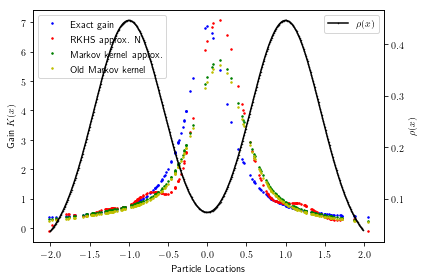

In [73]:
if __name__ == '__main__':
    
    ## Flags to be set to choose which methods to compare
    exact  = 1      # Computes the exact gain and plots 
    coif   = 1      # Computes gain using Coifman kernel method
    rkhs_N = 1      # Computes gain using subspace of RKHS
    rkhs_2N= 0      # Computes optimal gain using RKHS 
    om     = 0      # Computes gain using RKHS enforcing constant gain constraint
    memory = 0      # Computes gain using RKHS with a memory parameter for previous gain
    om_mem = 0      # Computes gain using const gain approx and a memory parameter for previous gain
    
    coif_old = 1   # Computes old implementation of Coifman kernel approx. 
    const  = 0      # Computes the constant gain approximation
    kalman = 0      # Runs Kalman Filter for comparison
    sis    = 0      # Runs Sequential Importance Sampling Particle Filter 

    # Run parameters
    No_runs = 100
    
    # FPF parameters - No. of particles
    N = 200
    
    # System parameters
    x = Symbol('x')
    dim = 1     # dimension of the system
    c = x       # Observation function
    c_x = lambdify(x, c, 'numpy')
        
    # Parameters of the prior density p(0) - 2 component Gaussian mixture density
    m = 2      # No of components in the Gaussian mixture
    sigma = [0.4472, 0.4472]
    mu  = [-1, 1]
    w   = [0.5, 0.5]
    w[-1] = 1 - sum(w[:-1])
    p = 0
    mu_eq = 0  # Equivalent mean of the density p
    for m in range(len(w)):
        p = p + w[m] * (1/ np.sqrt(2 * math.pi * sigma[m]**2))* exp(-(x - mu[m])**2/ (2* sigma[m]**2))
    p_vec = lambdify(x, p, 'numpy')
    
    mse_coif = np.zeros(No_runs)
    mse_rkhs_N = np.zeros(No_runs)
    mse_rkhs_2N = np.zeros(No_runs)
    mse_om   = np.zeros(No_runs)
    mse_coif_old = np.zeros(No_runs)
    for run in range(No_runs):
        clear_output()
        print('Run ',run)
        Xi  = get_samples(N, mu, sigma, w, dim)
        if dim == 1:
            Xi = np.sort(Xi,kind = 'mergesort')
        C   = c_x(Xi)
# To check consistency with Matlab code output - using the same samples 
#         Xi = np.loadtxt('Xi.txt')
#         Xi = np.sort(Xi,kind = 'mergesort')
#         Xi = np.reshape(Xi,(-1,1))
#         plt.figure()
#         sns.distplot(Xi)
#         plt.show()

        if exact == 1:
            # c_hat = mu_eq   # True only for c = x, linear function          
            # K_exact  = gain_exact(Xi, c, p)   # Manual numerical integration
            K_exact =  np.zeros((N,dim))
            K_exact[:,0] =  gain_num_integrate(Xi, c, p)  # Uses scipy.integrate function

        if coif ==1:
            eps_coif = 0.1
            Phi = np.zeros(N)
            K_coif = gain_coif(Xi, C, eps_coif, Phi, diag = 0)
            if exact == 1:
                mse_coif[run] = mean_squared_error(K_exact, K_coif, p)

        if rkhs_N == 1:
            eps_rkhs_N = 0.1
            Lambda_rkhs_N = 1e-3
            K_rkhs_N = gain_rkhs_N(Xi, C, eps_rkhs_N, Lambda_rkhs_N, diag = 0)
            if exact == 1:
                mse_rkhs_N[run] = mean_squared_error(K_exact, K_rkhs_N, p)

        if rkhs_2N == 1:
            eps_rkhs_2N = 0.1
            Lambda_rkhs_2N = 1e-3
            K_rkhs_2N = gain_rkhs_2N(Xi, C, eps_rkhs_2N, Lambda_rkhs_2N, diag = 0)
            if exact == 1:
                mse_rkhs_2N[run] = mean_squared_error(K_exact, K_rkhs_2N, p)

        if om == 1:
            eps_om = 0.1
            Lambda_om = 1e-3
            K_om = gain_rkhs_om(Xi, C, eps_om, Lambda_om, diag = 0)
            if exact == 1:
                mse_om[run] = mean_squared_error(K_exact, K_om, p)
                
        if coif_old == 1:
            eps_coif_old = 0.1
            Phi = np.zeros(N)
            K_coif_old = gain_coif_old(Xi, C, eps_coif, Phi, diag = 0)
            if exact == 1:
                mse_coif_old[run] = mean_squared_error(K_exact, K_coif_old, p)
         
    print('\n')
    if exact == 1 & coif == 1:
        print('MSE for Markov kernel approx', np.mean(mse_coif))
    if exact == 1 & rkhs_N == 1:
        print('MSE for RKHS N', np.mean(mse_rkhs_N))
    if exact == 1 & rkhs_2N == 1:
        print('MSE for RKHS 2N', np.mean(mse_rkhs_2N))
    if exact == 1 & om == 1:
        print('MSE for RKHS OM', np.mean(mse_om))
    if exact == 1 & coif_old == 1:
        print('MSE for old Markov kernel', np.mean(mse_coif_old))
    
    ### Displaying the plots
    marker_size  = 3
    plt.rc('text', usetex=True)
    fig,ax1 = plt.subplots()
    if exact == 1:
        ax1.plot(Xi, K_exact, 'b.', markersize = marker_size, label ='Exact gain')
        # ax1.plot(Xi, K_num_int, 'k^', markersize = marker_size, label ='Num int. gain')
    if rkhs_N == 1:
        ax1.plot(Xi, K_rkhs_N, 'r.', markersize = marker_size, label = 'RKHS approx. N')
    if rkhs_2N == 1:
        ax1.plot(Xi, K_rkhs_2N, 'c.', markersize = marker_size, label = 'RKHS approx. 2N')
    if coif == 1:
        ax1.plot(Xi, K_coif, 'g.', markersize = marker_size, label ='Markov kernel approx.')
    if om == 1:
        ax1.plot(Xi, K_om, 'm.', markersize = marker_size, label = 'RKHS OM')
    if coif_old == 1:
        ax1.plot(Xi, K_coif_old, 'y.', markersize = marker_size, label ='Old Markov kernel')
    ax2 =ax1.twinx()
    ax2.plot(np.arange(-2,2,0.01), p_vec(np.arange(-2,2,0.01)),'k.-', markersize =1, label = r'$\rho(x)$')
    ax2.set_ylabel(r'$\rho(x)$')
    ax2.legend(loc=1)
    ax1.set_xlabel('Particle Locations')
    ax1.set_ylabel('Gain $K(x)$')
    ax1.legend()
    plt.xticks(rotation = 45)
    plt.tight_layout()
    plt.show()     

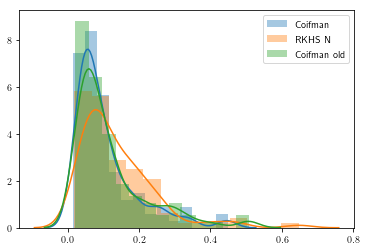

In [65]:
sns.distplot(mse_coif,label='Coifman')
sns.distplot(mse_rkhs_N, label = 'RKHS N')
sns.distplot(mse_coif_old, label = 'Coifman old')
plt.legend()
plt.show()

#### Multi-dimensional example in section 5.1  - https://arxiv.org/pdf/1902.07263.pdf  
\begin{equation}
\rho(x) = \rho_B(x_1) \prod_{n=2}^d \rho_G(x_n), \qquad \text{for } x = (x_1,x_2, \cdots, x_d) \in \mathbb{R}^d 
\end{equation}
Here, $\rho_B$ is $\frac{1}{2} \mathcal{N}(-1, \sigma^2) + \frac{1}{2}\mathcal{N}(+1,\sigma^2)$ is bimodal distribution  
$\rho_G$ is Gaussian distribution, $\mathcal{N}(0,\sigma^2)$  
Observation function, $h(x) = x_1$  
Exact gain function, $\text{K}_{\text{exact}}(x) = (\text{K}_{\text{exact}}(x_1), 0, \cdots,0)$  

Run  0
Time taken 0.33478776600168203
Time taken 51.44871090300148
Time taken 2.3510178540018387
Time taken 50.671535645000404


MSE for Markov kernel approx 0.2008438437139705
MSE for RKHS N 0.4389561894144797
MSE for old Markov kernel 0.24706252949255067


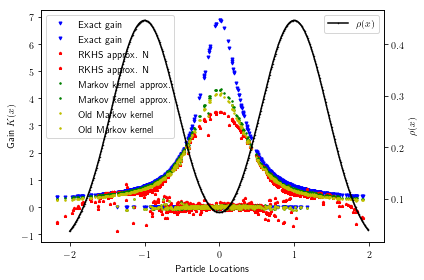

In [69]:
if __name__ == '__main__':
    
    ## Flags to be set to choose which methods to compare
    exact  = 1      # Computes the exact gain and plots 
    coif   = 1      # Computes gain using Coifman kernel method
    rkhs_N = 1      # Computes gain using subspace of RKHS
    rkhs_2N= 0      # Computes optimal gain using RKHS 
    om     = 0      # Computes gain using RKHS enforcing constant gain constraint
    memory = 0      # Computes gain using RKHS with a memory parameter for previous gain
    om_mem = 0      # Computes gain using const gain approx and a memory parameter for previous gain
    
    coif_old = 1    # Computes old implementation of Coifman kernel approx. 
    const  = 0      # Computes the constant gain approximation
    kalman = 0      # Runs Kalman Filter for comparison
    sis    = 0      # Runs Sequential Importance Sampling Particle Filter 

    # Run parameters
    No_runs = 1
    
    # FPF parameters - No. of particles
    N = 500
    
    # System parameters
    dim = 2     # dimension of the system
    x = symbols('x0:%d'%dim)
    c = x[0]       # Observation function
    # c_x = lambdify(x, c, 'numpy')
    c_x = lambdify(x[0], c, 'numpy')
        
    # Parameters of the prior density \rho_B - 2 component Gaussian mixture density
    m = 2      # No of components in the Gaussian mixture
    sigma_b = [0.4472, 0.4472]   # Gives \sigma^2 = 0.2
    mu_b  = [-1, 1]
    w_b   = [0.5, 0.5]
    w_b[-1] = 1 - sum(w_b[:-1])
    p_b = 0
    for m in range(len(w_b)):
        p_b = p_b + w_b[m] * (1/ np.sqrt(2 * math.pi * sigma_b[m]**2))* exp(-(x[0] - mu_b[m])**2/ (2* sigma_b[m]**2))
    p_b_x = lambdify(x[0], p_b, 'numpy')
    sigma = 0.4472  # Chosen so that \sigma^2 = 0.2 as in the reference
    p = p_b
    for d in np.arange(1,dim):
        p_g = exp(-x[d])**2/ (2 * sigma**2)
        p*= p_g
    
    
    mse_coif = np.zeros(No_runs)
    mse_rkhs_N = np.zeros(No_runs)
    mse_rkhs_2N = np.zeros(No_runs)
    mse_om   = np.zeros(No_runs)
    mse_coif_old = np.zeros(No_runs)
    for run in range(No_runs):
        print('Run ',run)
        Xi  = get_samples(N, mu_b, sigma_b, w_b, dim, sigma)
        get_samples
        if dim == 1:
            Xi = np.sort(Xi,kind = 'mergesort')
        C = np.reshape(c_x(Xi[:,0]),(len(Xi),1))
        # C   = np.reshape(c_x(Xi[:,0],Xi[:,1]),(len(Xi),1))
        
        if exact == 1:
         
            K_exact = np.zeros((N, dim))
            K_exact[:,0]  = gain_num_integrate(Xi, c, p_b)

        if coif ==1:
            eps_coif = 0.1
            Phi = np.zeros(N)
            K_coif = gain_coif(Xi, C, eps_coif, Phi, diag = 0)
            if exact == 1:
                mse_coif[run] = mean_squared_error(K_exact, K_coif, p)

        if rkhs_N == 1:
            eps_rkhs_N = 0.25
            Lambda_rkhs_N = 1e-2
            K_rkhs_N = gain_rkhs_N(Xi, C, eps_rkhs_N, Lambda_rkhs_N, diag = 0)
            if exact == 1:
                mse_rkhs_N[run] = mean_squared_error(K_exact, K_rkhs_N, p)

        if rkhs_2N == 1:
            eps_rkhs_2N = 0.1
            Lambda_rkhs_2N = 1e-3
            K_rkhs_2N = gain_rkhs_2N(Xi, C, eps_rkhs_2N, Lambda_rkhs_2N, diag = 0)
            if exact == 1:
                mse_rkhs_2N[run] = mean_squared_error(K_exact, K_rkhs_2N, p)

        if om == 1:
            eps_om = 0.1
            Lambda_om = 1e-3
            K_om = gain_rkhs_om(Xi, C, eps_om, Lambda_om, diag = 0)
            if exact == 1:
                mse_om[run] = mean_squared_error(K_exact, K_om, p)
                
        if coif_old == 1:
            eps_coif_old = 0.1
            Phi = np.zeros(N)
            K_coif_old = gain_coif_old(Xi, C, eps_coif, Phi, diag = 0)
            if exact == 1:
                mse_coif_old[run] = mean_squared_error(K_exact, K_coif_old, p)
         
    print('\n')
    if exact == 1 & coif == 1:
        print('MSE for Markov kernel approx', np.mean(mse_coif))
    if exact == 1 & rkhs_N == 1:
        print('MSE for RKHS N', np.mean(mse_rkhs_N))
    if exact == 1 & rkhs_2N == 1:
        print('MSE for RKHS 2N', np.mean(mse_rkhs_2N))
    if exact == 1 & om == 1:
        print('MSE for RKHS OM', np.mean(mse_om))
    if exact == 1 & coif_old == 1:
        print('MSE for old Markov kernel', np.mean(mse_coif_old))
    
    ### Displaying the plots
    marker_size  = 3
    plt.rc('text', usetex=True)
    fig,ax1 = plt.subplots()
    if exact == 1:
        ax1.plot(Xi, K_exact, 'bv', markersize = marker_size, label ='Exact gain')
    if rkhs_N == 1:
        ax1.plot(Xi, K_rkhs_N, 'r*', markersize = marker_size, label = 'RKHS approx. N')
    if rkhs_2N == 1:
        ax1.plot(Xi, K_rkhs_2N, 'cs', markersize = marker_size, label = 'RKHS approx. 2N')
    if coif == 1:
        ax1.plot(Xi, K_coif, 'g.', markersize = marker_size, label ='Markov kernel approx.')
    if om == 1:
        ax1.plot(Xi, K_om, 'm*', markersize = marker_size, label = 'RKHS OM')
    if coif_old == 1:
        ax1.plot(Xi, K_coif_old, 'y.', markersize = marker_size, label ='Old Markov kernel')
    ax2 =ax1.twinx()
    ax2.plot(np.arange(-2,2,0.01), p_b_x(np.arange(-2,2,0.01)),'k.-', markersize =1, label = r'$\rho(x)$')
    ax2.set_ylabel(r'$\rho(x)$')
    ax2.legend(loc=1)
    ax1.set_xlabel('Particle Locations')
    ax1.set_ylabel('Gain $K(x)$')
    ax1.legend()
    plt.xticks(rotation = 45)
    plt.tight_layout()
    plt.show()     

In [ ]:
mse_coif

In [ ]:
mse_rkhs_N

In [ ]:
mse_coif_old

### Rough trials

In [ ]:
f = lambda x:  x * (0.498677850501791*exp(-3.125*(x + 1)**2) + 0.498677850501791*exp(-3.125*(x - 1)**2))

In [ ]:
expf = lambda x:

In [ ]:
cp

In [ ]:
integrate.quad(expf, 0, 1)

In [ ]:
integrate.quad(f,-np.inf,np.inf)

In [ ]:
f2 = lambda x: c*p

In [ ]:
cp_vec = lambdify(x, c, 'numpy')

In [ ]:
np.mean(cp_vec(Xi))

In [ ]:
f = lambda x: cp(c,p,x)

In [ ]:
help(Symbol)